# Firm Entry and Exit Problem

In [1]:
import numpy as np
import time
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import quantecon as qe

### 1. Define the recursive competitive equilibrium

Household maximise utility:
<br>$\underset{C_{t}, N_{t}, K_{t+1}}{\text{max}} \quad E\sum_{t = 0}^{\infty} \beta^{t} (log(C_{t} + a N_{t})$
<br>$\text{subject to, } C_{t} + (K_{t+1} - (1 - \delta) K_{t}) = w_{t} N_{t} + r_{t} K_{t} , \; \forall t$

Euler equation:
<br>$C_{t} = \beta (C_{t+1})^{-1} ((1 - \delta) + r_{t+1})$

Firms maximize profit:
<br>$\underset{w_{t}, r_{t}}{\text{max}} \quad e^{z_{t}} K_{t}^{\theta} N_{t}^{\nu} - w_{t} N_{t} - K_{t} r_{r}$

The free entry condition:
<br>$c_{e} \leq \int v(\varepsilon, 0) \nu(d \varepsilon)$

Market clearing conditions: 
<br>$N(z, g)=\int n(\varepsilon, k ; z, g) g(\varepsilon, k) d \varepsilon d k$
<br>$C(z, g)=\int y(\varepsilon, k ; z, g)  - i(\varepsilon, k ; z, g) d \varepsilon d k$

* The distribution of active firms $g^*(\epsilon,k)$ is stationary

In [2]:
def Tauchen(n_epsilon, rho, sigma, m = 3):
    zmax = m*np.sqrt(sigma**(2)/(1 - rho**(2)))
    zmin = - m*np.sqrt(sigma**(2)/(1 - rho**(2)))
    z = [0]*n_epsilon
    ztilde = [0]*(n_epsilon - 1)
    for i in range(n_epsilon - 1):
        if i == 0:
            z[i] = zmin
        else:
            z[i] = zmin + ((zmax - zmin)/(n_epsilon-1))*(i)
    z[n_epsilon-1] = (zmax)
    for i in range(n_epsilon-1):
        ztilde[i] = (z[i+1] + z[i])/2
    pi = np.zeros([n_epsilon, n_epsilon])
    for i in range(n_epsilon):
        for j in range(n_epsilon):
            if j == 0:
                pi[i][j] = norm.cdf((ztilde[j] - rho*z[i])/sigma)
            elif j in range(1, n_epsilon-1):
                pi[i][j] = norm.cdf((ztilde[j] - rho*z[i])/sigma) - norm.cdf((ztilde[j-1] - rho*z[i])/sigma)
            elif j == (n_epsilon -1):
                pi[i][j] = 1 - norm.cdf((ztilde[j-1] - rho*z[i])/sigma)
    return z, pi

### 2. Solve for representative agent steady state

In [3]:
# Set parameters
theta = 0.21
nu = 0.64
delta = 0.1
beta = 0.96
phi = 0.5
rho = 0.9
sigma = 0.02
n_epsilon = 10
Nbar = 0.6

# Steady state equation
rbar = (1/beta) - (1 - delta)
Kbar = (rbar/(Nbar**(nu)*theta))**(1/(theta - 1))
wbar = nu*Kbar**(theta)*Nbar**(nu - 1)
cbar = wbar*Nbar + rbar*Kbar - Kbar + (1 - delta)*Kbar
print("K*= ", Kbar, ", w*= ", wbar)

K*=  1.0881001887382777 , w*=  0.7829715643830996


### 3. Solve For Incumbent Firms’ Decision Rules

In [4]:
wstar = 0.78297
cf = 0.01
varphi = 0.5

def my_n(wbar, k, nu, epsilon, theta):
    n = (wbar/(nu*np.e**(epsilon)*k**(theta)))**(1/(nu-1))
    return n

#Define the value iteration function ValIter
def val_fn(num_points, params):

    #unwrap params
    varphi, theta, nu, delta, beta, phi, rho, sigma, cf, wstar = params
    #Set n_epsilon for Tauchen Method
    n_epsilon = 10
    #Set the threshold below which the value function is deemed to have converged
    threshold = 1e-10
    #Initialize the difference to be something large
    difference = 10000
    # number of grid-points for the capital grid
    N = num_points 
    # Set lower bound for captial
    k_low =  0.0000001
    # Set upper boud for capital
    k_high = 10
    #Create grid for capital based on user input
    k_grid = np.linspace(k_low, k_high, N)
    #Get grid of shocks and their transition probabilities
    shocks, transition = Tauchen(n_epsilon, rho, sigma)
    # Now we initialize the value function by setting it to zero, two dimensional because two states
    V_old = np.zeros((len(shocks), N))  
    #Initialize the utility matrix
    obj = np.zeros_like(V_old)
    #Initialize V1
    V1 = np.zeros_like(V_old)
    #Initialize the new value function
    V_new = np.zeros_like(V_old)
    #Initialize the policy function
    policy = np.zeros_like(V_old)
    #Set iteration number to zero
    itr = 0
    
    while difference > threshold:
        print("Iteration:", str(itr), str(difference) )
        for i in range(len(k_grid)):
            #Get value of capital in this period
            k = k_grid[i]
            #Compute n for objective function
            for j in range(len(shocks)):
                epsilon = shocks[j]
                n = my_n(wstar, k, nu, epsilon, theta)
                #Firm's objective function
                obj[j, :] = np.e**(epsilon)*k**(theta)*n**(nu) -\
                wstar*n - (k_grid-(1-delta)*k) - (varphi/2)*((k_grid/k) - (1 - delta))**(2)*k
            #Compute function to be maximized over all future k given current capital k_grid[i]
            actionvalue_allchoices = obj + beta * np.dot(transition, V_old)
            V1[:, i] = np.max(actionvalue_allchoices, axis = 1)       
            max_indicies = np.argmax(actionvalue_allchoices, axis = 1)
            policy[:, i] = k_grid[max_indicies]
            
        arg1 = np.ones([V1.shape[0],1])*(1-delta)*k_grid           
        V_new = np.maximum(arg1, V1 - cf)
        policy[arg1 > V1 - cf] = 0
        difference = np.linalg.norm(V_new - V_old)**2
        V_old = V_new.copy()
        itr += 1
    indicator = np.zeros_like(policy)
    indicator[policy > 0] = 1
    #Now solve optimization problem deterimining firm entry
    mc = qe.MarkovChain(transition)
    stat_distr = mc.stationary_distributions
    my_vec = -k_grid + beta*np.dot(stat_distr, V_new)
    V_E0 = np.max(my_vec)
    SV_E0 = np.sum(stat_distr*V_E0)
    return k_grid, shocks, V_new, policy, V_E0, SV_E0, transition, indicator
    

params = [varphi, theta, nu, delta, beta, phi, rho, sigma, cf, wstar]

k_grid, shocks, V_new, policy, V_E0, SV_E0, transition, indicator  = val_fn(100, params)

k, eps = np.meshgrid(k_grid, shocks)

Iteration: 0 10000
Iteration: 1 27164.68591353412
Iteration: 2 37.635861510845196
Iteration: 3 34.84156894288795
Iteration: 4 29.124145351659763
Iteration: 5 21.63142071040586
Iteration: 6 15.899182019010304
Iteration: 7 12.260917067933372
Iteration: 8 9.86020010107245
Iteration: 9 8.205884114779177
Iteration: 10 6.987219164785432
Iteration: 11 6.065602768887531
Iteration: 12 5.340418774966137
Iteration: 13 4.741331040330567
Iteration: 14 4.2447670103016755
Iteration: 15 3.826919081836413
Iteration: 16 3.4683814812236027
Iteration: 17 3.1558494756494406
Iteration: 18 2.8797941951785346
Iteration: 19 2.63374038002262
Iteration: 20 2.412771551930906
Iteration: 21 2.213208826521295
Iteration: 22 2.03218065455066
Iteration: 23 1.8674253750964414
Iteration: 24 1.7170835903600514
Iteration: 25 1.5796045280560218
Iteration: 26 1.453679656309159
Iteration: 27 1.3381891060940698
Iteration: 28 1.2321609971169434
Iteration: 29 1.1347425822581283
Iteration: 30 1.045178748088534
Iteration: 31 0.962

Iteration: 234 6.093717721509198e-08
Iteration: 235 5.615970252396915e-08
Iteration: 236 5.175678184591146e-08
Iteration: 237 4.7699050148156755e-08
Iteration: 238 4.395944461650814e-08
Iteration: 239 4.051302415990272e-08
Iteration: 240 3.733680306295012e-08
Iteration: 241 3.440959770440057e-08
Iteration: 242 3.171188524369534e-08
Iteration: 243 2.9225673440361667e-08
Iteration: 244 2.6934380643122444e-08
Iteration: 245 2.4822725201329446e-08
Iteration: 246 2.2876623545527618e-08
Iteration: 247 2.10830962597627e-08
Iteration: 248 1.9430181512060203e-08
Iteration: 249 1.790685528163661e-08
Iteration: 250 1.650295782894256e-08
Iteration: 251 1.520912593447504e-08
Iteration: 252 1.4016730461079052e-08
Iteration: 253 1.2917818793325207e-08
Iteration: 254 1.1905061798823039e-08
Iteration: 255 1.097170495475899e-08
Iteration: 256 1.0111523286448037e-08
Iteration: 257 9.318779860786806e-09
Iteration: 258 8.588187519159613e-09
Iteration: 259 7.914873617960068e-09
Iteration: 260 7.294347525181

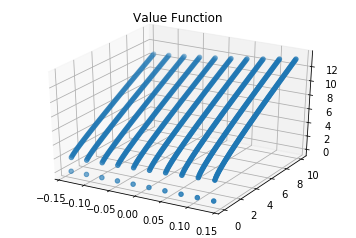

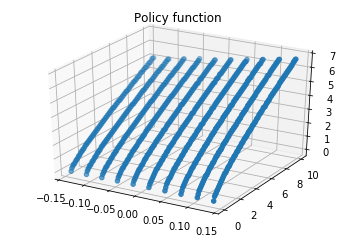

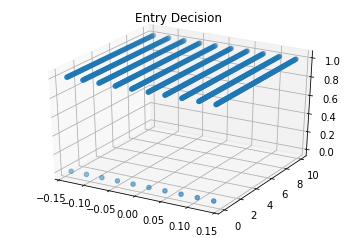

In [5]:
fig = plt.figure()
ax1 = plt.axes(projection = "3d")
ax1.scatter(eps, k, V_new)
plt.title("Value Function")
plt.show()

fig = plt.figure()
ax2 = plt.axes(projection = "3d")
ax2.scatter(eps, k, policy)
# ax.set_xlabel("k")
# ax.set_ylabel("z")
# ax.set_zlabel("k'")
plt.title("Policy function")
plt.show()

indicator = np.zeros_like(policy)
indicator[policy > 0] = 1
#Create indicator function for entry
fig = plt.figure()
ax3 = plt.axes(projection = "3d")
ax3.scatter(eps, k, indicator)
plt.title("Entry Decision")
plt.show()

### 4. Compute the market-clearing wage

In [6]:
def euler_fn(w, params):
    num_points = 50
    ce = 0.02
    varphi, theta, nu, delta, beta, phi, rho, sigma, cf = params
    params = [varphi, theta, nu, delta, beta, phi, rho, sigma, cf, w]
    k_grid, shocks, V_new, policy, V_E0, SV_E0, transition, indicator = val_fn(num_points, params)
    final_diff = SV_E0 - ce
    return final_diff

fparams = [varphi, theta, nu, delta, beta, phi, rho, sigma, cf]
results = opt.root(euler_fn, 0.6, fparams)
w = results.fun
print("Market clearing wage: ", w)

Iteration: 0 10000
Iteration: 1 14073.62080604821
Iteration: 2 179.19823810407172
Iteration: 3 117.77500199107442
Iteration: 4 85.54413935179065
Iteration: 5 66.60216430793191
Iteration: 6 55.163412776379275
Iteration: 7 47.361654504337224
Iteration: 8 41.5089494282415
Iteration: 9 36.84079680556401
Iteration: 10 32.96324379430034
Iteration: 11 29.675419882374907
Iteration: 12 26.830085283325495
Iteration: 13 24.342774678316832
Iteration: 14 22.146475121603967
Iteration: 15 20.19741448742521
Iteration: 16 18.456188443090284
Iteration: 17 16.892233295664255
Iteration: 18 15.480639355655311
Iteration: 19 14.201830075964047
Iteration: 20 13.040074137426018
Iteration: 21 11.981922878321937
Iteration: 22 11.016035164603277
Iteration: 23 10.132728332415818
Iteration: 24 9.323760648745557
Iteration: 25 8.581992534086437
Iteration: 26 7.9011774435718
Iteration: 27 7.275810381922647
Iteration: 28 6.701012083175552
Iteration: 29 6.172418861427895
Iteration: 30 5.686111925809936
Iteration: 31 5.2

Iteration: 240 2.0323583726932998e-07
Iteration: 241 1.8730214762900513e-07
Iteration: 242 1.7261765926180862e-07
Iteration: 243 1.5908443477162177e-07
Iteration: 244 1.4661221508251787e-07
Iteration: 245 1.3511781742054522e-07
Iteration: 246 1.2452458053834023e-07
Iteration: 247 1.1476185342227057e-07
Iteration: 248 1.0576452411349168e-07
Iteration: 249 9.747258542409126e-08
Iteration: 250 8.983073472296347e-08
Iteration: 251 8.278800512348342e-08
Iteration: 252 7.629742552055132e-08
Iteration: 253 7.031570736027717e-08
Iteration: 254 6.480295590138554e-08
Iteration: 255 5.972240415834902e-08
Iteration: 256 5.504016767129296e-08
Iteration: 257 5.072501852912406e-08
Iteration: 258 4.674817707613744e-08
Iteration: 259 4.308311999276931e-08
Iteration: 260 3.970540338589265e-08
Iteration: 261 3.659249976034472e-08
Iteration: 262 3.3723647777803854e-08
Iteration: 263 3.107971379401653e-08
Iteration: 264 2.8643064233258273e-08
Iteration: 265 2.6397447996891027e-08
Iteration: 266 2.432788807

Iteration: 147 0.0004032282450300966
Iteration: 148 0.0003716151506196734
Iteration: 149 0.0003424805228110425
Iteration: 150 0.00031563004982276816
Iteration: 151 0.0002908846539167188
Iteration: 152 0.000268079297049556
Iteration: 153 0.0002470618801609544
Iteration: 154 0.00022769222875629525
Iteration: 155 0.00020984115802182056
Iteration: 156 0.00019338961123299166
Iteration: 157 0.00017822786571229903
Iteration: 158 0.0001642548010404041
Iteration: 159 0.00015137722463871433
Iteration: 160 0.0001395092502271494
Iteration: 161 0.00012857172500938216
Iteration: 162 0.00011849170176858706
Iteration: 163 0.00010920195234994184
Iteration: 164 0.0001006405192857396
Iteration: 165 9.275030257372971e-05
Iteration: 166 8.547867885189798e-05
Iteration: 167 7.877715042988146e-05
Iteration: 168 7.260102183618579e-05
Iteration: 169 6.690910172420024e-05
Iteration: 170 6.166342814905742e-05
Iteration: 171 5.6829015382258876e-05
Iteration: 172 5.237362057617463e-05
Iteration: 173 4.826752872305

Iteration: 48 1.3057495371900614
Iteration: 49 1.2033715118218806
Iteration: 50 1.1090218362191757
Iteration: 51 1.0220705837568425
Iteration: 52 0.9419373469142877
Iteration: 53 0.8680873199548662
Iteration: 54 0.8000276979527743
Iteration: 55 0.7373043649351162
Iteration: 56 0.6794988466817249
Iteration: 57 0.6262255061134827
Iteration: 58 0.5771289612780645
Iteration: 59 0.5318817077650885
Iteration: 60 0.49018192899629
Iteration: 61 0.45175147927286896
Iteration: 62 0.4163340257498478
Iteration: 63 0.3836933366672464
Iteration: 64 0.3536117042164661
Iteration: 65 0.3258884913723918
Iteration: 66 0.3003387928883951
Iteration: 67 0.27679220144197214
Iteration: 68 0.2550916706417762
Iteration: 69 0.23509246726845592
Iteration: 70 0.21666120572884484
Iteration: 71 0.1996749582597798
Iteration: 72 0.1840204349292743
Iteration: 73 0.16959322795326806
Iteration: 74 0.15629711527821116
Iteration: 75 0.1440434187777411
Iteration: 76 0.13275041277785127
Iteration: 77 0.12234277896171049
Iter

Iteration: 285 5.157167825495414e-09
Iteration: 286 4.752845867553682e-09
Iteration: 287 4.380222752565906e-09
Iteration: 288 4.036813289479359e-09
Iteration: 289 3.7203271270007336e-09
Iteration: 290 3.428653480002166e-09
Iteration: 291 3.159847046863974e-09
Iteration: 292 2.9121150385225255e-09
Iteration: 293 2.6838052191498224e-09
Iteration: 294 2.473394890454418e-09
Iteration: 295 2.279480731044784e-09
Iteration: 296 2.1007694410546945e-09
Iteration: 297 1.9360691172505705e-09
Iteration: 298 1.784281298369993e-09
Iteration: 299 1.6443936444841964e-09
Iteration: 300 1.5154731831506305e-09
Iteration: 301 1.3966600854183982e-09
Iteration: 302 1.2871619348958358e-09
Iteration: 303 1.1862484390942002e-09
Iteration: 304 1.0932465614184837e-09
Iteration: 305 1.0075360311299212e-09
Iteration: 306 9.285452064554207e-10
Iteration: 307 8.557472620554118e-10
Iteration: 308 7.88656676503748e-10
Iteration: 309 7.268259935141216e-10
Iteration: 310 6.698428354411751e-10
Iteration: 311 6.1732715703

Iteration: 191 1.1102464565089417e-05
Iteration: 192 1.0232031343180882e-05
Iteration: 193 9.42984008586807e-06
Iteration: 194 8.690540623135292e-06
Iteration: 195 8.009202238286455e-06
Iteration: 196 7.381280782832095e-06
Iteration: 197 6.8025883694306895e-06
Iteration: 198 6.269265441263192e-06
Iteration: 199 5.777755030662471e-06
Iteration: 200 5.3247790362742735e-06
Iteration: 201 4.9073163598207505e-06
Iteration: 202 4.522582757217861e-06
Iteration: 203 4.168012269059326e-06
Iteration: 204 3.8412401071500465e-06
Iteration: 205 3.5400868827583243e-06
Iteration: 206 3.2625440711432252e-06
Iteration: 207 3.006760615978131e-06
Iteration: 208 2.771030583666161e-06
Iteration: 209 2.553781785887282e-06
Iteration: 210 2.353565293902404e-06
Iteration: 211 2.1690457748654103e-06
Iteration: 212 1.9989925861134336e-06
Iteration: 213 1.8422715673550608e-06
Iteration: 214 1.6978374764767833e-06
Iteration: 215 1.5647270183131936e-06
Iteration: 216 1.442052420073581e-06
Iteration: 217 1.328995510

Iteration: 93 0.0053597158656506815
Iteration: 94 0.004939514146923278
Iteration: 95 0.004552256241853335
Iteration: 96 0.004195359355677769
Iteration: 97 0.0038664431846963236
Iteration: 98 0.003563314040982639
Iteration: 99 0.003283950221711451
Iteration: 100 0.0030264885255379594
Iteration: 101 0.002789211826082238
Iteration: 102 0.002570537619657568
Iteration: 103 0.002369007470855475
Iteration: 104 0.0021832772855932157
Iteration: 105 0.0020121083467565075
Iteration: 106 0.0018543590526465044
Iteration: 107 0.0017089773031346747
Iteration: 108 0.001574993482736555
Iteration: 109 0.0014515139938208422
Iteration: 110 0.0013377152968072428
Iteration: 111 0.0012328384176169237
Iteration: 112 0.0011361838857377538
Iteration: 113 0.0010471070691440187
Iteration: 114 0.0009650138749603564
Iteration: 115 0.0008893567871925264
Iteration: 116 0.0008196312150991881
Iteration: 117 0.000755372127853343
Iteration: 118 0.0006961509530433434
Iteration: 119 0.0006415727183350541
Iteration: 120 0.0

Iteration: 3 10.142482370709752
Iteration: 4 9.2118318674301
Iteration: 5 7.077574818017239
Iteration: 6 5.134154800677814
Iteration: 7 3.8647777806596935
Iteration: 8 3.0492791351966195
Iteration: 9 2.485516587538493
Iteration: 10 2.087717755074644
Iteration: 11 1.7833526303558673
Iteration: 12 1.5494857215664102
Iteration: 13 1.373262481057738
Iteration: 14 1.2379934546872375
Iteration: 15 1.1245239513913878
Iteration: 16 1.0258812304503755
Iteration: 17 0.9385624155506653
Iteration: 18 0.8602626248477339
Iteration: 19 0.7885342445661698
Iteration: 20 0.7226394567546753
Iteration: 21 0.6628084300843404
Iteration: 22 0.6083846073142967
Iteration: 23 0.558799969814104
Iteration: 24 0.5135318784677392
Iteration: 25 0.4721610621001054
Iteration: 26 0.43431286711964495
Iteration: 27 0.3996536565576835
Iteration: 28 0.36788579844293207
Iteration: 29 0.33874667320454455
Iteration: 30 0.3119708624435276
Iteration: 31 0.2873426176833762
Iteration: 32 0.26468252539149334
Iteration: 33 0.243828

Iteration: 239 1.2076124585153837e-08
Iteration: 240 1.1129356417744825e-08
Iteration: 241 1.0256814874093973e-08
Iteration: 242 9.452680588443507e-09
Iteration: 243 8.711590429646447e-09
Iteration: 244 8.02860173972747e-09
Iteration: 245 7.399159362805121e-09
Iteration: 246 6.819065269517632e-09
Iteration: 247 6.284450552185534e-09
Iteration: 248 5.791749629154473e-09
Iteration: 249 5.337676458687764e-09
Iteration: 250 4.919202623946056e-09
Iteration: 251 4.533537137657406e-09
Iteration: 252 4.178107826022375e-09
Iteration: 253 3.850544172667728e-09
Iteration: 254 3.5486615097255716e-09
Iteration: 255 3.270446447611361e-09
Iteration: 256 3.0140434459390138e-09
Iteration: 257 2.7777424396640895e-09
Iteration: 258 2.559967432249434e-09
Iteration: 259 2.359265985665501e-09
Iteration: 260 2.174299532639659e-09
Iteration: 261 2.0038344488839128e-09
Iteration: 262 1.8467338283415012e-09
Iteration: 263 1.7019498961151077e-09
Iteration: 264 1.5685170244415697e-09
Iteration: 265 1.445545289613

Iteration: 169 9.092594421312201e-07
Iteration: 170 8.379734684234124e-07
Iteration: 171 7.722763197958776e-07
Iteration: 172 7.117298316842188e-07
Iteration: 173 6.559301917418476e-07
Iteration: 174 6.045052465637956e-07
Iteration: 175 5.571120196562089e-07
Iteration: 176 5.134344239521277e-07
Iteration: 177 4.7318115363876746e-07
Iteration: 178 4.360837413445352e-07
Iteration: 179 4.0189476757522626e-07
Iteration: 180 3.703862105472379e-07
Iteration: 181 3.4134792541382675e-07
Iteration: 182 3.145862427185078e-07
Iteration: 183 2.8992267670319967e-07
Iteration: 184 2.671927349176879e-07
Iteration: 185 2.462448211242055e-07
Iteration: 186 2.2693922424538074e-07
Iteration: 187 2.091471865780094e-07
Iteration: 188 1.9275004501386152e-07
Iteration: 189 1.7763843965490578e-07
Iteration: 190 1.6371158441202812e-07
Iteration: 191 1.508765948434773e-07
Iteration: 192 1.390478686497935e-07
Iteration: 193 1.281465147521688e-07
Iteration: 194 1.1809982714567213e-07
Iteration: 195 1.088407999615

Iteration: 117 1.237197285170937e-05
Iteration: 118 1.140152613585037e-05
Iteration: 119 1.0507222880588139e-05
Iteration: 120 9.683085888590492e-06
Iteration: 121 8.923607518659842e-06
Iteration: 122 8.223712754216461e-06
Iteration: 123 7.578725182516056e-06
Iteration: 124 6.984335653573046e-06
Iteration: 125 6.436573407811221e-06
Iteration: 126 5.931779477036931e-06
Iteration: 127 5.4665821795318005e-06
Iteration: 128 5.0378745439200524e-06
Iteration: 129 4.6427935094704835e-06
Iteration: 130 4.278700763109213e-06
Iteration: 131 3.943165083673017e-06
Iteration: 132 3.6339460749478507e-06
Iteration: 133 3.3489791778099763e-06
Iteration: 134 3.0863618608948157e-06
Iteration: 135 2.8443408968633846e-06
Iteration: 136 2.6247484855156047e-06
Iteration: 137 2.422124153349216e-06
Iteration: 138 2.2321959735224166e-06
Iteration: 139 2.0571623604102293e-06
Iteration: 140 1.89585505626416e-06
Iteration: 141 1.7471974601125636e-06
Iteration: 142 1.6101974336800334e-06
Iteration: 143 1.483940672

Iteration: 88 2.417650430274297e-05
Iteration: 89 2.228085546499557e-05
Iteration: 90 2.0615295503329747e-05
Iteration: 91 1.900439935025882e-05
Iteration: 92 1.751433328646171e-05
Iteration: 93 1.6141109239484778e-05
Iteration: 94 1.4878089414586169e-05
Iteration: 95 1.376732886065769e-05
Iteration: 96 1.268791415971202e-05
Iteration: 97 1.1693135222749061e-05
Iteration: 98 1.0776354945917557e-05
Iteration: 99 9.931456859826827e-06
Iteration: 100 9.152804262682846e-06
Iteration: 101 8.435202565849563e-06
Iteration: 102 7.78581350926093e-06
Iteration: 103 7.194609487581106e-06
Iteration: 104 6.630539519807768e-06
Iteration: 105 6.110694801640852e-06
Iteration: 106 5.63160770132849e-06
Iteration: 107 5.190082513458463e-06
Iteration: 108 4.783174128919491e-06
Iteration: 109 4.408168379036386e-06
Iteration: 110 4.0625639223036444e-06
Iteration: 111 3.7440555524724843e-06
Iteration: 112 3.450518816373537e-06
Iteration: 113 3.187689097796569e-06
Iteration: 114 2.9429958339151277e-06
Iterati

Iteration: 70 5.708458276074198e-06
Iteration: 71 5.271195771980104e-06
Iteration: 72 4.8463073404263215e-06
Iteration: 73 4.446193387026403e-06
Iteration: 74 4.079263583770646e-06
Iteration: 75 3.742738258069611e-06
Iteration: 76 3.4340755637817706e-06
Iteration: 77 3.1509502402524373e-06
Iteration: 78 2.8912344239186606e-06
Iteration: 79 2.6529802885577406e-06
Iteration: 80 2.434404318372333e-06
Iteration: 81 2.2338730423901715e-06
Iteration: 82 2.0498900795409645e-06
Iteration: 83 1.8810843614892388e-06
Iteration: 84 1.7261994160023123e-06
Iteration: 85 1.584083606730645e-06
Iteration: 86 1.4536812371474752e-06
Iteration: 87 1.3340244362291342e-06
Iteration: 88 1.2242257525158038e-06
Iteration: 89 1.1234713907274218e-06
Iteration: 90 1.0310150319595282e-06
Iteration: 91 9.461721844881557e-07
Iteration: 92 8.683150174230949e-07
Iteration: 93 7.968676341676589e-07
Iteration: 94 7.313017467693896e-07
Iteration: 95 6.711327159802688e-07
Iteration: 96 6.159159251009347e-07
Iteration: 97 

Iteration: 101 4.754404742720124e-08
Iteration: 102 4.315769188342209e-08
Iteration: 103 3.91760747624863e-08
Iteration: 104 3.556183798800771e-08
Iteration: 105 3.228107415435687e-08
Iteration: 106 2.9303007294375465e-08
Iteration: 107 2.659970328448494e-08
Iteration: 108 2.4145807111666476e-08
Iteration: 109 2.1918304496435137e-08
Iteration: 110 1.9896305598845782e-08
Iteration: 111 1.8060848752611107e-08
Iteration: 112 1.639472236445225e-08
Iteration: 113 1.4882303287926559e-08
Iteration: 114 1.3509410147792976e-08
Iteration: 115 1.2263170222008315e-08
Iteration: 116 1.1131898629794884e-08
Iteration: 117 1.0104988680827624e-08
Iteration: 118 9.172812357498066e-09
Iteration: 119 8.326629986115418e-09
Iteration: 120 7.558508253583771e-09
Iteration: 121 6.861245791419434e-09
Iteration: 122 6.228305633793577e-09
Iteration: 123 5.653753907556897e-09
Iteration: 124 5.132204183914013e-09
Iteration: 125 4.658766966520778e-09
Iteration: 126 4.22900384077025e-09
Iteration: 127 3.8388858548174

Iteration: 25 9.38161299902186e-05
Iteration: 26 8.258841748068699e-05
Iteration: 27 7.16315278854151e-05
Iteration: 28 6.229192274102381e-05
Iteration: 29 5.429624324512069e-05
Iteration: 30 4.742383700991754e-05
Iteration: 31 4.1495583396529106e-05
Iteration: 32 3.6365198324969615e-05
Iteration: 33 3.191247149944062e-05
Iteration: 34 2.8038001389374918e-05
Iteration: 35 2.465908711727107e-05
Iteration: 36 2.1706512554555092e-05
Iteration: 37 1.9122018449295335e-05
Iteration: 38 1.6957140671615815e-05
Iteration: 39 1.5240172370986525e-05
Iteration: 40 1.344899957530837e-05
Iteration: 41 1.1873130902914511e-05
Iteration: 42 1.0485652019516981e-05
Iteration: 43 9.263150105468492e-06
Iteration: 44 8.18533089331072e-06
Iteration: 45 7.234556047598995e-06
Iteration: 46 6.395459192484976e-06
Iteration: 47 5.654625292009465e-06
Iteration: 48 5.00032138955409e-06
Iteration: 49 4.423014038080669e-06
Iteration: 50 3.937733797785011e-06
Iteration: 51 3.4832521674459535e-06
Iteration: 52 3.081431

Iteration: 121 6.596687162565301e-10
Iteration: 122 5.838388493539509e-10
Iteration: 123 5.167257353435587e-10
Iteration: 124 4.573273706832994e-10
Iteration: 125 4.0475693369094186e-10
Iteration: 126 3.5822954411278226e-10
Iteration: 127 3.1705054486829e-10
Iteration: 128 2.8060513077694877e-10
Iteration: 129 2.483491693376238e-10
Iteration: 130 2.1980107695410828e-10
Iteration: 131 1.9453462870808424e-10
Iteration: 132 1.721725948944025e-10
Iteration: 133 1.52381108915734e-10
Iteration: 134 1.3486468256117932e-10
Iteration: 135 1.1936179449789296e-10
Iteration: 136 1.0564098560435668e-10
Iteration: 0 10000
Iteration: 1 13637.758408673346
Iteration: 2 0.01076869066015354
Iteration: 3 0.010645662414366784
Iteration: 4 0.010178596287648877
Iteration: 5 0.007771879937658387
Iteration: 6 0.0043406965531850444
Iteration: 7 0.0022606430176326277
Iteration: 8 0.0018499295273789482
Iteration: 9 0.0014762614046378237
Iteration: 10 0.0012058176224566393
Iteration: 11 0.0009891947104243807
Itera

Iteration: 78 1.2581618032025287e-07
Iteration: 79 1.1135261218820872e-07
Iteration: 80 9.855184942773408e-08
Iteration: 81 8.722270250199351e-08
Iteration: 82 7.719597089563727e-08
Iteration: 83 6.832191266401947e-08
Iteration: 84 6.046800553786927e-08
Iteration: 85 5.351696589609921e-08
Iteration: 86 4.736499585045862e-08
Iteration: 87 4.192023212007595e-08
Iteration: 88 3.710137343154535e-08
Iteration: 89 3.2836465876148735e-08
Iteration: 90 2.9061828010434364e-08
Iteration: 91 2.5721099622681677e-08
Iteration: 92 2.2764399914492543e-08
Iteration: 93 2.0147582507645462e-08
Iteration: 94 1.7831576131716552e-08
Iteration: 95 1.5781801131545773e-08
Iteration: 96 1.396765307350334e-08
Iteration: 97 1.2362045730458319e-08
Iteration: 98 1.0941006613580293e-08
Iteration: 99 9.683319011178787e-09
Iteration: 100 8.570205182999163e-09
Iteration: 101 7.58504597691263e-09
Iteration: 102 6.713132682364931e-09
Iteration: 103 5.941447410124717e-09
Iteration: 104 5.258468723217838e-09
Iteration: 10